# EOF Analysis of AR days

* Multivariate EOF analysis in T-mode
* K-means clustering

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import ar_climatology
from kmeans import *

In [2]:
# Set up paths

home = Path.home()                                # users home directory
root = home/'DATA'/'repositories'/'AR_types'      # project root directory
path_to_data = home/'DATA'/'data'                 # project data -- read only
path_to_out  = root/'out'                         # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = root/'figs'                        # figures

# check that path exists
path_to_figs.exists()

True

In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### AR time series

In [4]:
# Read CSV data into pandas DataFrame
filename = path_to_data / 'CH1_generated_data/ar_catalog_fraction_HASIAsubregions.nc'
ds = xr.open_dataset(filename)

#For MERRA2 IVT
ds = ds.sel(time=slice('1980-01-01', '2018-12-31'))

R01_dates = ar_climatology(ds.R01, 0.3)
R02_dates = ar_climatology(ds.R02, 0.3)
R03_dates = ar_climatology(ds.R03, 0.3)


In [5]:
thres = 0.3

df = ds.to_dataframe()
## drop lev and ens cols
df = df.drop(columns=['lev', 'ens'])
## resample to daily
df = df.resample('1D').mean()
# Add column of AR days based on threshold
# (no LLJ day eq 0; LLJ day eq 1)
df['ar'] = 0
idx = (df['R01'] > thres) | (df['R02'] > thres) | (df['R03'] > thres)
df.loc[idx, 'ar'] = 1

# Add column of AR locations 
# ('R01', 'R02', 'R03', 'R01/R02', 'R02/R03', 'R01/R03', 'R01/R02/R03', nan)
df['location'] = np.nan

idx = (df['R01'] >= thres) & (df['R02'] < thres) & (df['R03'] < thres)
df.loc[idx, 'location'] = 'R01'

idx = (df['R01'] < thres) & (df['R02'] >= thres) & (df['R03'] < thres)
df.loc[idx, 'location'] = 'R02'

idx = (df['R01'] < thres) & (df['R02'] < thres) & (df['R03'] >= thres)
df.loc[idx, 'location'] = 'R03'

idx = (df['R01'] >= thres) & (df['R02'] >= thres) & (df['R03'] < thres)
df.loc[idx, 'location'] = 'R01/R02'

idx = (df['R01'] < thres) & (df['R02'] >= thres) & (df['R03'] >= thres)
df.loc[idx, 'location'] = 'R02/R03'

idx = (df['R01'] >= thres) & (df['R02'] < thres) & (df['R03'] >= thres)
df.loc[idx, 'location'] = 'R01/R03'

idx = (df['R01'] >= thres) & (df['R02'] >= thres) & (df['R03'] >= thres)
df.loc[idx, 'location'] = 'R01/R02/R03'

# Show table
df.head()

,R01,R02,R03,ar,location
time,,,,,
1980-01-01,0.0,0.0,0.000000,0,NaN
1980-01-02,0.0,0.0,0.072829,0,NaN
1980-01-03,0.0,0.0,0.000000,0,NaN
1980-01-04,0.0,0.0,0.000000,0,NaN
1980-01-05,0.0,0.0,0.000000,0,NaN


### MERRA2 reanalysis

In [6]:
# Select lat/lon grid
lonmin = 0
lonmax = 120
latmin = 0
latmax =  50

### MERRA2 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

filepath_pattern = '/home/sbarc/students/nash/data/MERRA2/anomalies/IVT/daily_*.nc'
merra = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(merra.nbytes / 1e9))

# ## Use if IVT
# new_times = pd.date_range('1980-01-01-09', '2018-12-31-09', freq='D')
# ds_z['time'] = new_times
# ds_z['ivt'] = np.sqrt(ds_z.ivtx**2 + ds_z.ivty**2)
merra
# ds_z = ds_z.load()

ds size in GB 4.44



<xarray.Dataset>
Dimensions:    (lat: 101, lon: 193, time: 14245)
Coordinates:
  * lat        (lat) float64 0.0 0.5 1.0 1.5 2.0 ... 48.0 48.5 49.0 49.5 50.0
  * lon        (lon) float64 0.0 0.625 1.25 1.875 ... 118.1 118.8 119.4 120.0
  * time       (time) datetime64[ns] 1980-01-01 ... 2018-12-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(366,), meta=np.ndarray>
Data variables:
    ivtx       (time, lat, lon) float64 dask.array<chunksize=(366, 101, 193), meta=np.ndarray>
    ivty       (time, lat, lon) float64 dask.array<chunksize=(366, 101, 193), meta=np.ndarray>

In [7]:
# Read datafiles into xarray datasets
# f2 = xr.open_dataset(path_to_data/'era5.sam.05dg.ivtn.1979-2016.nc')

# Add LLJ time series to era5; set as coordinate variables
merra['ar'] = ('time', df.ar)
merra = merra.set_coords('ar')

merra['location'] = ('time', df.location)
merra = merra.set_coords('location')

# print dataset
print(merra)

<xarray.Dataset>
Dimensions:    (lat: 101, lon: 193, time: 14245)
Coordinates:
  * lat        (lat) float64 0.0 0.5 1.0 1.5 2.0 ... 48.0 48.5 49.0 49.5 50.0
  * lon        (lon) float64 0.0 0.625 1.25 1.875 ... 118.1 118.8 119.4 120.0
  * time       (time) datetime64[ns] 1980-01-01 ... 2018-12-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(366,), meta=np.ndarray>
    ar         (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location   (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    ivtx       (time, lat, lon) float64 dask.array<chunksize=(366, 101, 193), meta=np.ndarray>
    ivty       (time, lat, lon) float64 dask.array<chunksize=(366, 101, 193), meta=np.ndarray>


### Data Subset Selection

In [8]:
# Trim date range
start_date = '1980-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
merra = merra.sel(time=idx)

# Select NDJFM months
idx = (merra.time.dt.month >= 12) | (merra.time.dt.month <= 2)
merra = merra.sel(time=idx)

# Select AR days
idx = (merra.ar >= 1)
merra_ar = merra.sel(time=idx)

# print results
print(merra_ar)

<xarray.Dataset>
Dimensions:    (lat: 101, lon: 193, time: 379)
Coordinates:
  * lat        (lat) float64 0.0 0.5 1.0 1.5 2.0 ... 48.0 48.5 49.0 49.5 50.0
  * lon        (lon) float64 0.0 0.625 1.25 1.875 ... 118.1 118.8 119.4 120.0
  * time       (time) datetime64[ns] 1980-12-12 ... 2018-02-26T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(4,), meta=np.ndarray>
    ar         (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location   (time) object 'R01' 'R01' 'R02' 'R02' ... 'R03' 'R03' 'R01' 'R01'
Data variables:
    ivtx       (time, lat, lon) float64 dask.array<chunksize=(4, 101, 193), meta=np.ndarray>
    ivty       (time, lat, lon) float64 dask.array<chunksize=(4, 101, 193), meta=np.ndarray>


In [9]:
# Count number of independent AR events

years = np.arange(1980, 2018) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single DJF season
    date1 = "{}-12-01".format(years[k])
    date2 = "{}-02-28".format(years[k+1])
    x = merra.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  215


### Climatology and Anomalies

In [10]:
# # Mean IVT of AR days in DJF
# merra_ar_clim = merra_ar.mean(dim='time')
# #print(merra_ar_clim, '\n')

# # IVT Anomalies
# merra_ar['ivtx'] = era_llj.ivte - era_llj_clim.ivte
# era_llj['ivtn_anom'] = era_llj.ivtn - era_llj_clim.ivtn
# #print(era_llj)

## Preprocessing

### Reshape, center, and standardize data matrix

In [11]:
%%time
# Load merra_ar dataset into memory
merra_ar = merra_ar.load()


CPU times: user 4.5 s, sys: 3min 39s, total: 3min 43s
Wall time: 11min 40s


In [15]:
def center_data(in_array):
    ''' Remove the mean of an array along the first dimension.
    
    If *True*, the mean along the first axis of *dataset* (the
    time-mean) will be removed prior to analysis. If *False*,
    the mean along the first axis will not be removed. Defaults
    to *True* (mean is removed).
    The covariance interpretation relies on the input data being
    anomaly data with a time-mean of 0. Therefore this option
    should usually be set to *True*. Setting this option to
    *True* has the useful side effect of propagating missing
    values along the time dimension, ensuring that a solution
    can be found even if missing values occur in different
    locations at different times.
    '''
    # Compute the mean along the first dimension.
    mean = in_array.mean(axis=0, skipna=False)
    # Return the input array with its mean along the first dimension
    # removed.
    return (in_array - mean)


def spatial_weights(latitude):
    """Spatial weights
    
    Returns a 1D array of weights equal to the sqrt of the cos of latitude.
    
    Parameters
    ----------
    latitude : 1D array, float
        latitudes in degrees
  
    Returns
    -------
    weights : 1D array, float
        weights equal to the sqrt of the cosine of latitude
    
    Example
    -------
    # Apply spatial weights using xarray
    wgts = spatial_weights(lats)            # compute weights
    era['wgts'] = ('latitude', wgts)        # add `wgts` to dataset
    era['uwnd_wgt'] = era.uwnd * era.wgts   # apply wgts to data variable
    
    """
    # convert lats from degrees to radians
    lat_rad = np.deg2rad(latitude)
    # compute weights
    weights = np.sqrt(np.cos(lat_rad))
    
    return weights

def remove_missing_values(X):
    # Find the indices of values that are missing in the whole row
    nonMissingIndex = np.where(np.logical_not(np.isnan(X[0])))[0]
    # Remove missing values from the design matrix.
    dataNoMissing = X[:, nonMissingIndex]
    return nonMissingIndex, dataNoMissing

def valid_nan(in_array):
    inan = np.isnan(in_array)
    return (inan.any(axis=0) == inan.all(axis=0)).all()

def standardize_and_flatten_arrays(arr1, arr2):

    # Data dimensions with missing values removed
    ntim, npts = arr1.shape

    # Transpose arrays to get [space x time]
    X1 = arr1.T
    X2 = arr2.T

   # Center and standardize by columns
    x1mean = np.mean(X1, axis=0)
    x1std = np.std(X1, axis=0)
    X1s = (X1-x1mean) / x1std

    x2mean = np.mean(X2, axis=0)
    x2std = np.std(X2, axis=0)
    X2s = (X2-x2mean) / x2std

    # Combine variables into single data matrix Xs
    Xs = np.empty((nvar*npts,ntim))
    Xs[0:npts,:] = X1s
    Xs[npts:,:]  = X2s
    print(Xs.shape)

    # Check that column means=0 and std dev=1
    test = np.mean(np.mean(Xs, axis=0))
    print("Column means: ", np.round(test,2))
    test = np.mean(np.std(Xs, axis=0))
    print("Column std: ", np.round(test,2))
    
    return Xs

In [18]:
# Center the variables by removing long-term mean
var1 = center_data(merra_ar.ivtx)
var2 = center_data(merra_ar.ivty)

# var1 = merra_ar.ivtx
# var2 = merra_ar.ivty

# Weight the data by the square root of the cosine of the lat
wgts = spatial_weights(merra_ar.lat)
var1 = var1*wgts
var2 = var2*wgts

In [19]:
%%time
# Extract variables as numpy arrays
var1 = var1.values
var2 = var2.values

# Data dimensions
ntim, nlat, nlon = var1.shape
npts = nlat*nlon
nvar = 2

# Reshape into 2D arrays by flattening the spatial dimension
tmp1 = np.reshape(var1, (ntim, npts))
tmp2 = np.reshape(var2, (ntim, npts))

# Remove missing data
tmp1_idx, tmp1_miss = remove_missing_values(tmp1)
tmp2_idx, tmp2_miss = remove_missing_values(tmp2)

## Test if the removal of nans was successful
print(valid_nan(tmp1_miss), valid_nan(tmp2_miss))



True True
CPU times: user 86.8 ms, sys: 61.8 ms, total: 149 ms
Wall time: 147 ms


In [20]:
## Standardize and flatten variable arrays
Xs = standardize_and_flatten_arrays(tmp1_miss, tmp2_miss)
Xs_nomiss = standardize_and_flatten_arrays(tmp1, tmp2)

(13540, 379)
Column means:  0.0
Column std:  1.0
(38986, 379)
Column means:  nan
Column std:  nan


## EOF Analysis

In [22]:
def calc_eofs(z):
    """Eigenvector decomposition of covariance/correlation matrix
    
    Parameters
    ----------
    z : array_like, float
        matrix of data values [nxp];
        n = number of observations (rows);
        p = number of variables (columns)
        
    Returns
    -------
    evals : array_like, float
        vector of eigenvalues of size [p]
    evecs : array_like, float
        pxp matrix of eigenvectors (columns)
    
    """
    # Compute covariance/correlation matix [R]
    ntot = z.shape[0]
    R = np.matmul(z.T,z) / (ntot - 1.)

    # Eigenvector decomposition of R
    evals, evecs = np.linalg.eig(R)

    return evals, evecs

In [23]:
%%time
# Compute eigenvalues & eigenvectors
evals, evecs = calc_eofs(Xs)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (379,)
[4.43553075e+01 2.97854396e+01 2.43349794e+01 1.95028437e+01
 1.74188925e+01 1.40881864e+01 1.20588528e+01 1.08930532e+01
 1.06320072e+01 1.02037506e+01 8.37341048e+00 7.68673680e+00
 7.29662074e+00 6.99245251e+00 6.59904763e+00 6.27104077e+00
 5.57754746e+00 5.19615352e+00 4.87340687e+00 4.76997821e+00
 4.38932273e+00 4.13592722e+00 3.92133653e+00 3.57359224e+00
 3.35961234e+00 3.24583149e+00 3.03967702e+00 2.96292629e+00
 2.58509084e+00 2.55869360e+00 2.43410004e+00 2.34136072e+00
 2.32288092e+00 2.23399415e+00 2.08737973e+00 2.03146929e+00
 1.86283186e+00 1.76528631e+00 1.72830208e+00 1.65893291e+00
 1.62601706e+00 1.55893455e+00 1.52592456e+00 1.40797630e+00
 1.38937484e+00 1.32766713e+00 1.28079606e+00 1.24024179e+00
 1.21162251e+00 1.18417162e+00 1.14923895e+00 1.08411121e+00
 1.05919185e+00 1.05122763e+00 9.94730603e-01 9.59078169e-01
 9.23998794e-01 9.16038782e-01 8.79945926e-01 8.63042516e-01
 8.39152946e-01 8.15576107e-01 7.92702046e-01 7.71583330e-01
 7.

### Explained Variance

In [24]:
def pct_variance(eig):
    var_eig = eig/sum(eig)*100
    return var_eig

In [25]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 23 EOFs:
70.03% 

Cumulative variance explained by the first 4 EOFs:
25.98% 

1 	 11.70%
2 	 7.86%
3 	 6.42%
4 	 5.15%


### North Test

In [26]:
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[12.831  8.616  7.04   5.642  5.039  4.075]
[11.702  7.858  6.42   5.145  4.596  3.717]
[10.574  7.1    5.801  4.649  4.152  3.358]


### Fig 2: Variance

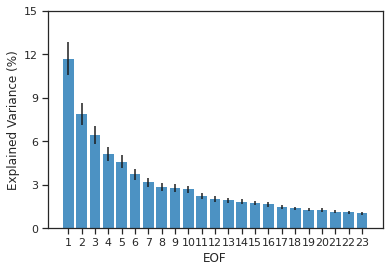

In [27]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,16,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs / 'fig2.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [28]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(379, 19)
[[ 0.027 -0.203  0.169 ... -0.159  0.089  0.242]
 [ 0.034 -0.343  0.033 ... -0.105  0.069  0.238]
 [-0.425  0.168  0.173 ... -0.037 -0.017  0.11 ]
 ...
 [-0.245 -0.059 -0.134 ...  0.199  0.019  0.023]
 [-0.154 -0.1    0.087 ... -0.076 -0.178  0.107]
 [-0.294  0.008  0.461 ...  0.141 -0.088  0.1  ]]


### Save EOFs

In [29]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out / 'eigenvalues.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out / 'eigenvectors.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out / 'loadings.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [30]:
def calc_pcs(z, evecs, npcs):
    """Calculate principal components from eigenvalues and eigenvectors
    
    Parameters
    ----------
    z : array_like, float
        standardized data matrix
    evecs : array_like, float
        pxk matrix of eigenvectors (columns), where k<=p (may be truncated)
    npcs : scalar, int
        number of pcs to return
        
    Returns
    -------
    pcs : array_like, float
        .........
    
    """   
    tmp = np.matmul(z, evecs[:,0:npcs])
    pcs = tmp.T
    
    return pcs

In [31]:
# Calculate principal components (spatial modes)
neofs = 19
pcs = calc_pcs(Xs_nomiss, evecs, neofs)
# pcs = calc_pcs(Xs, evecs, neofs)

In [32]:
# npts = len(tmp1_idx)

# # Combine missing idx into single data matrix
# tmp_idx = np.empty((nvar*npts))
# print(tmp_idx.shape)
# tmp_idx[0:npts] = tmp1_idx
# tmp_idx[npts:]  = tmp2_idx
# print(tmp_idx.shape)

# ## create an array of nans that is the size of the original unmasked array
# pcs_comb = np.ones([neofs, nvar*nlat*nlon], dtype=Xs.dtype) * np.NaN
# ## fill in array with values of pcs at indexed values from tmp_idx
# for count, ele in enumerate(tmp_idx):
#     pcs_comb[:, int(ele)] = pcs[:,count]
# print(pcs_comb.shape)

In [33]:
# Split pcs into separate arrays for each variable
tmp1 = pcs[:,0:npts]
tmp2 = pcs[:,npts:]
# tmp1 = pcs_comb[:,0:nlat*nlon]
# tmp2 = pcs_comb[:,nlat*nlon:]

# Reshape spatial dim back to 2D map
pcmodes_var1 = np.reshape(tmp1, (neofs,nlat,nlon))
pcmodes_var2 = np.reshape(tmp2, (neofs,nlat,nlon))
#print(pcmodes_var1.shape, pcmodes_var2.shape)

### Fig 3: Spatial Modes

In [34]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting
lons = merra_ar.lon.data
lats = merra_ar.lat.data
udat = pcmodes_var1[0:neofs,:,:]
vdat = pcmodes_var2[0:neofs,:,:]
# data = np.sqrt(udat**2 + vdat**2)
data = udat**2
print(np.nanmin(data), np.nanmax(data))

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

nan nan


/home/sbarc/students/nash/anaconda3/envs/ar_types/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]


/home/sbarc/students/nash/anaconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/sbarc/students/nash/anaconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


ValueError: 'bboxes' cannot be empty

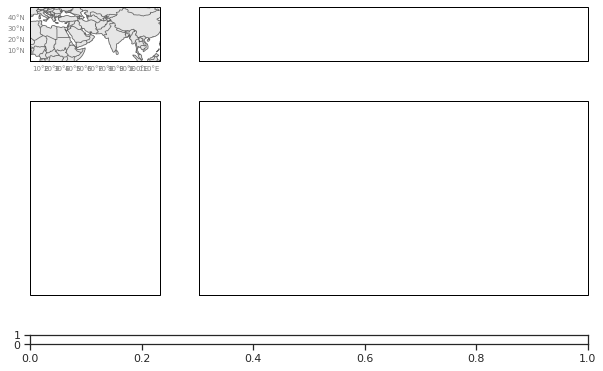

In [35]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 2

sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Add contour fill plot
    clevs = np.arange(0,100,5)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="Blues", extend='max')
    # add vectors
    ax.quiver(lons, lats, udat[k,:,:], vdat[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=20)      
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('kg m$^{-1}$ s$^{-1}$', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
filepath = path_to_figs / 'eofs.png'
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

## K means clustering

In [3]:
# Determine optimal K

# maximum number of clusters (number of iterations)
kmax =15
# number of eofs
neofs = 4
# input data
xdata = loads[:,0:neofs]

# Elbow plot
outfile = path_to_figs / 'xfig1.png'
plot_optimal_k(xdata, kmax, filename=outfile)


NameError: name 'loads' is not defined

In [ ]:
## K-means cluster analysis

# Number of clusters
nk = 4

# Input data
xdata = loads[:,0:neofs]

# Compute k means and assign each point to a cluster
kmeans = KMeans(n_clusters=nk)
kmeans.fit(xdata)
cluster = kmeans.predict(xdata)

# LLJ category labels (llj days only)
llj_cat = cluster + 1


In [ ]:
# Count number of days in each cluster
klabels, counts = np.unique(llj_cat, return_counts=True)

# Save counts to txt file
res = np.column_stack((klabels,counts))
headstr = 'LLJ_TYPE, COUNT'
outfile = path_to_out / 'k_counts.txt'
np.savetxt(outfile, res, delimiter=',', fmt='%d', header=headstr)


In [ ]:
# Cluster centroids (nclust x neofs)
centroids = kmeans.cluster_centers_

# Save centroids to txt file
res = np.column_stack((klabels,centroids))
headstr = "LLJ_TYPE, EOF1, EOF2, EOF3, EOF4"
outfile = path_to_out / 'centroids.txt'
np.savetxt(outfile, res, delimiter=',', fmt='%s', header=headstr)


### Save LLJ category labels

In [ ]:
## Save LLJ location, loadings (EOF1-4), and category label (LLJ days only)

# Vector of LLJ dates
dates_lljDays = era_llj.time.values

# Create new dataframe
data = {'LOC':era_llj.location.values,
        'EOF1':loads[:,0],
        'EOF2':loads[:,1],
        'EOF3':loads[:,2],
        'EOF4':loads[:,3],
        'LLJ_CAT':llj_cat}
df_out = pd.DataFrame(data, index=dates_lljDays)
print(df_out)

# Export dataframe as csv
outfile = path_to_out / 'sallj-types-loadings.csv'
df_out.to_csv(outfile)


In [ ]:
## Save time series of all NDJFM days with SALLJ types

# Arrays with ALL NDJFM days
dates_allDays = era.time.values
llj_cat_allDays = np.zeros(len(dates_allDays), dtype=int)

# Loop over llj days and match to llj_full 
for i, date in enumerate(dates_lljDays):
    idx = np.where(dates_allDays == date)
    llj_cat_allDays[idx] = llj_cat[i]  

# Create dataframe
data = {'LLJ_CAT':llj_cat_allDays}
df_out = pd.DataFrame(data, index=dates_allDays)
print(df_out)

outfile = path_to_out / 'sallj-types-ndjfm.csv'
df_out.to_csv(outfile)
